In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Params

In [3]:
# Helper function to visualise per-pixel time series data as a grid of little line graphs
# Vars: list of 3D numpy arrays for each variable
# Labels: None or list of strings to describe each variable
def visualise(vars, labels=None):
    height, width = vars[0].shape[1:]
    fig, axes = plt.subplots(height, width, sharex=True, sharey=True, figsize=(15,10))
    for i in range(height):
        for j in range(width):
            actors = [axes[i,j].plot(v[:,i,j])[0] for v in vars]
            
            axes[i,j].get_xaxis().set_visible(False)
            axes[i,j].get_yaxis().set_visible(False)
    
    if labels is not None:
        fig.legend(actors, labels, loc="lower center", ncol=len(labels))

# Helper function to hide axes ticks etc on axis
def hide_axes(axis):
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)

In [4]:
# Resolution of ommatidia array and number of timesteps to simulate
WIDTH = 16
HEIGHT = 16
TIMESTEPS = 16

# Stimuli generation

In [5]:
# Size of stimuli and it's y coordinate
STIM_WIDTH = 2
STIM_HEIGHT = 2
STIM_Y = 8

# Generate TIMESTEPS long 'video' of stimuli moving across frame
images = np.ones((TIMESTEPS, HEIGHT, WIDTH))
for i in range(TIMESTEPS):
    images[i,STIM_Y:STIM_Y+STIM_HEIGHT,i:i+STIM_WIDTH] = 0.0

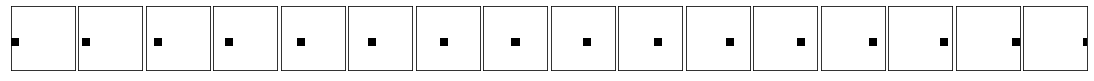

In [6]:
# Visualize stimuli
fig, axes = plt.subplots(1,TIMESTEPS, sharey=True, figsize=(15,5))
for t, a in enumerate(axes):
    a.imshow(images[t,:,:], cmap="gray")
    hide_axes(a)
fig.tight_layout(pad=0)


# High-pass filters
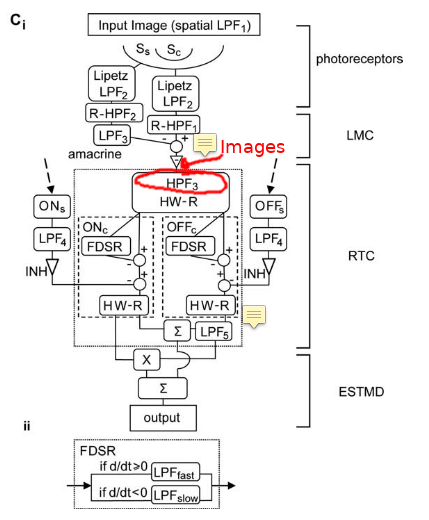

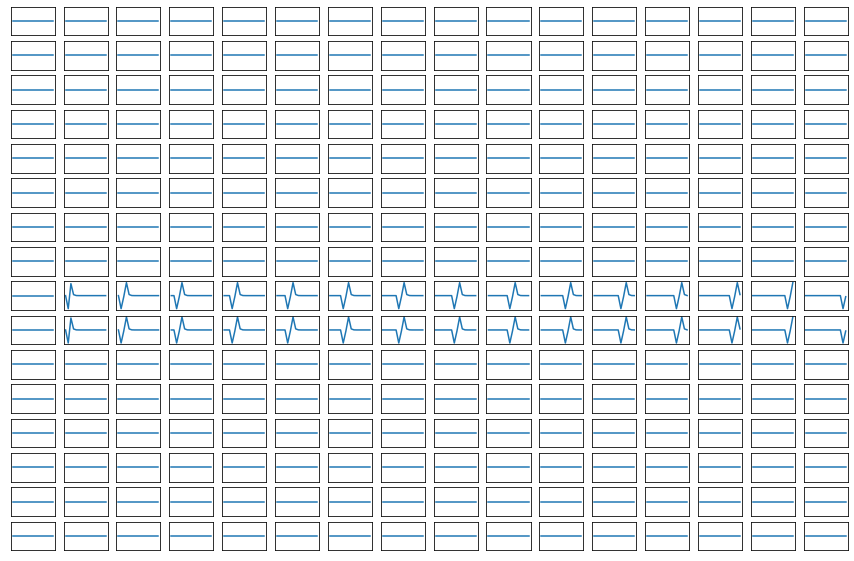

In [7]:
# First layer of the model is a high-pass filter which has 
# the effect of turning frames into DVS style on and off events
LPF_TAU = 0.4

# EMA time constant
LPF_K = np.exp(-1 / LPF_TAU)

lpf = np.ones((TIMESTEPS, HEIGHT, WIDTH))
f = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    lpf[t] = (LPF_K * lpf[t - 1]) + ((1.0 - LPF_K) * images[t])
    f[t] = (images[t] - lpf[t])


visualise([f])

# Half-wave rectification
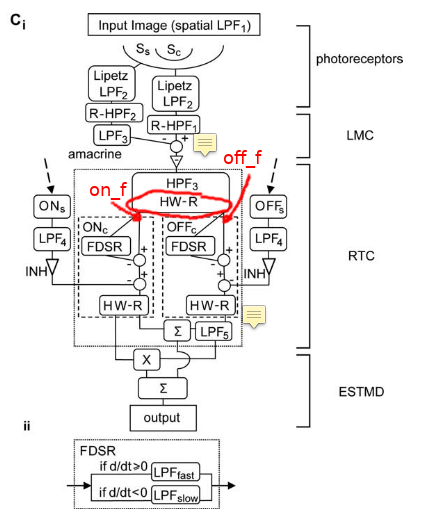

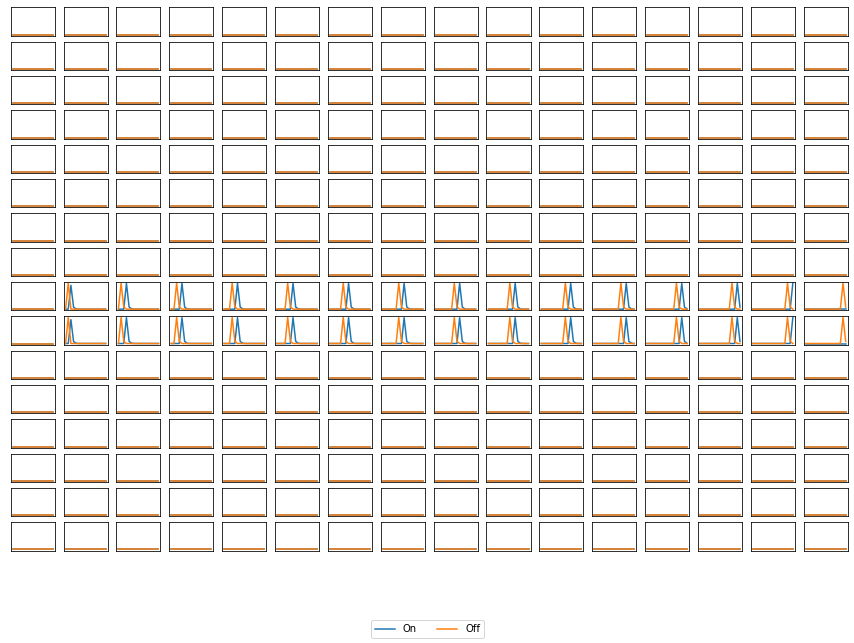

In [8]:
# Clamp the high pass filtered data to seperate the on and off channels
on_f = np.maximum(f, 0.0)
off_f = -np.minimum(f, 0.0)

visualise([on_f, off_f], ["On", "Off"])

# Calculate low-pass filtering
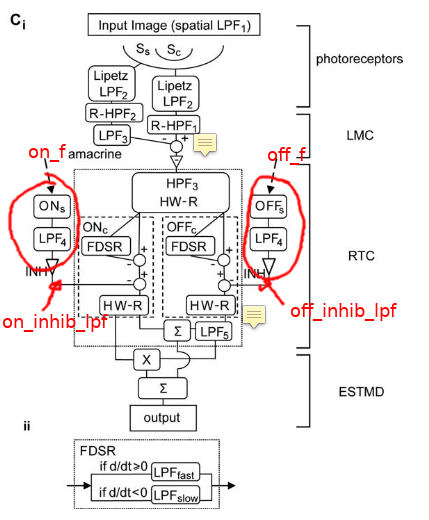

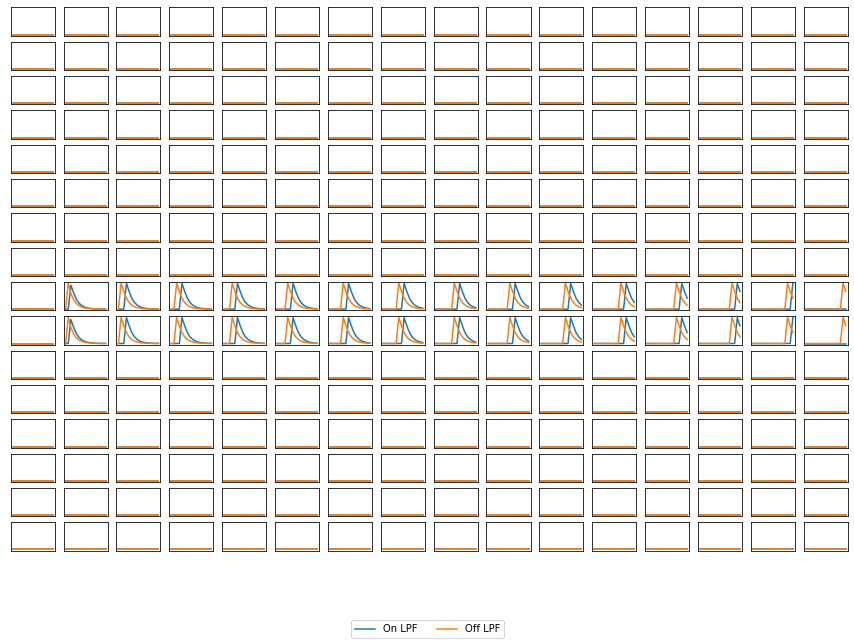

In [9]:
# Convert time constant of low pass filter into a decay to use in a simple low-pass filter
INHIB_LPF_TAU = 2.0
INHIB_LPF_K = np.exp(-1 / INHIB_LPF_TAU)

# Apply low-pass filter to on and off channel
on_inhib_lpf = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
off_inhib_lpf = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    on_inhib_lpf[t] = (INHIB_LPF_K * on_inhib_lpf[t - 1]) + ((1.0 - INHIB_LPF_K) * on_f[t])
    off_inhib_lpf[t] = (INHIB_LPF_K * off_inhib_lpf[t - 1]) + ((1.0 - INHIB_LPF_K) * off_f[t])

visualise([on_inhib_lpf, off_inhib_lpf], ["On LPF", "Off LPF"])

# Calculate inhibition
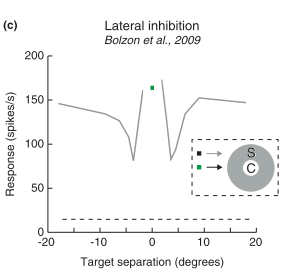

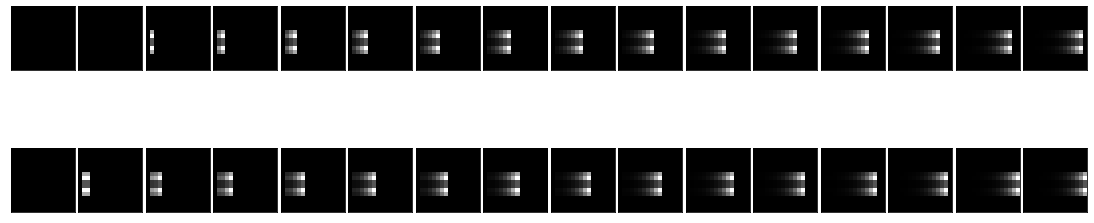

In [11]:
# Define 1D kernel
INHIB_KERNEL = 0.2 * np.asarray([2.0, 1.0, 0.0, 1.0, 2.0])

# Convolve the 1D kernel with low-pass filtered input every timestep
on_conv_inhib = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
off_conv_inhib = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(TIMESTEPS):
    on_conv_inhib[t] = cv2.filter2D(on_inhib_lpf[t], -1, INHIB_KERNEL)
    off_conv_inhib[t] = cv2.filter2D(off_inhib_lpf[t], -1, INHIB_KERNEL)

# Visualise
fig, axes = plt.subplots(2,TIMESTEPS, sharey=True, figsize=(15, 5))
for t in range(TIMESTEPS):
    axes[0,t].imshow(on_conv_inhib[t,:,:], cmap="gray")
    axes[1,t].imshow(off_conv_inhib[t,:,:], cmap="gray")
    
    hide_axes(axes[0,t])
    hide_axes(axes[1,t])
fig.tight_layout(pad=0)

# FDSR
"Fast depolarization, slow repolarization (FDSR). If the input signal is ‘depolarizing’ (positive temporal gradient), a first-order low pass filter with a small time constant (LPFfast) is used, otherwise for a ‘repolarizing’ signal (negative gradient) a larger time constant is applied (LPFslow). The resulting processed signal represents an ‘adaptation state’ which then subtractively inhibits the unaltered pass-through signal"
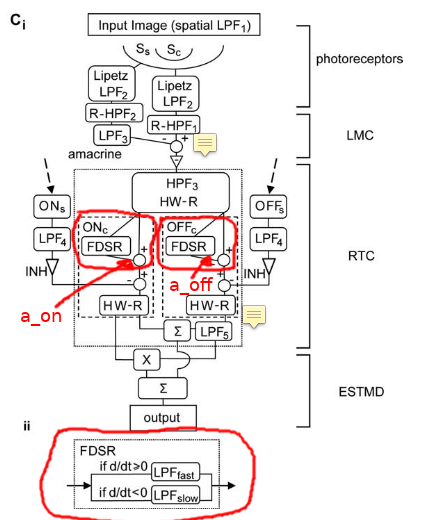

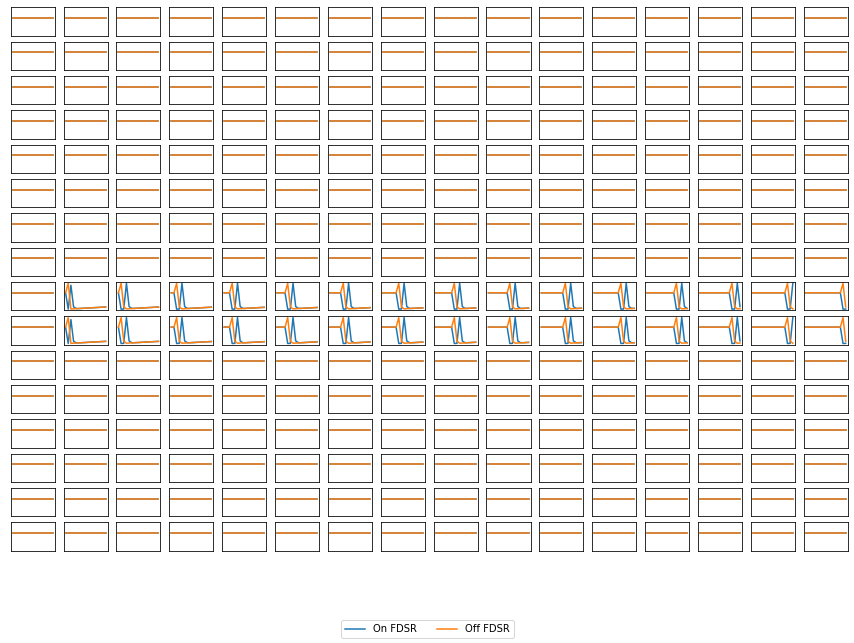

In [13]:
# Convert two time constants required for FDSR into decays to use in simple low-pass filters
FDSR_TAU_FAST = 1
FDSR_TAU_SLOW = 100
FSR_K_FAST = np.exp(-1 / FDSR_TAU_FAST)
FSR_K_SLOW = np.exp(-1 / FDSR_TAU_SLOW)

# Depending on instantaneous temporal gradients, pick K values for each pixel at each timestep
k_on = np.where((on_f[1:,:,:] - on_f[:-1,:,:]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
k_off = np.where((off_f[1:,:,:] - off_f[:-1,:,:]) > 0.0, FSR_K_FAST, FSR_K_SLOW)
    
# Apply low-pass filters to on and off channels
a_on = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
a_off = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
for t in range(1, TIMESTEPS):
    a_on[t] = ((1.0 - k_on[t - 1]) * on_f[t]) + (k_on[t - 1] * a_on[t - 1]) 
    a_off[t] = ((1.0 - k_off[t - 1]) * off_f[t]) + (k_off[t - 1] * a_off[t - 1]) 
    
visualise([on_f - a_off, off_f - a_off], ["On FDSR", "Off FDSR"])

# Half-wave rectification
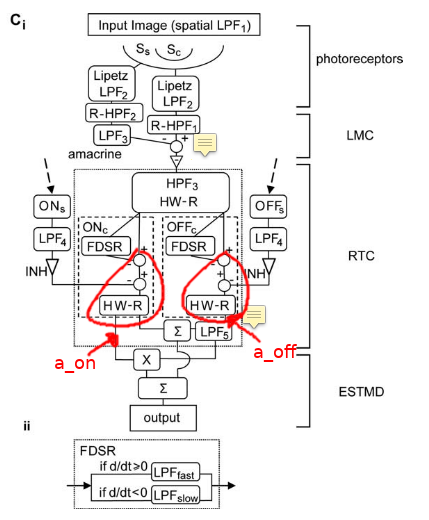

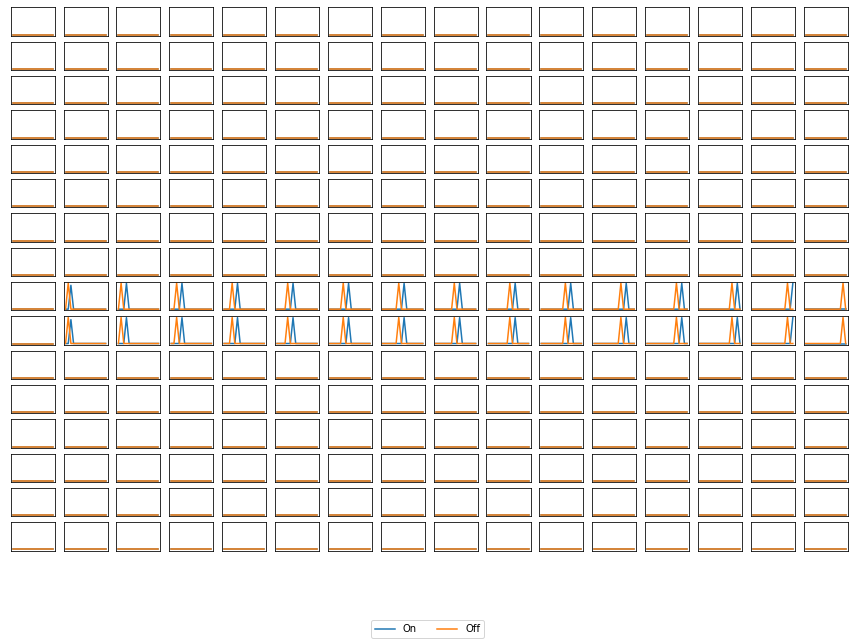

In [28]:
# Subtract output of FDSR and inhibitory signal from each channel and rectify again 
# **NOTE** because we're only implementing one direction we only take positive channels
a_on = np.maximum(0.0, on_f - a_on - on_conv_inhib)
a_off = np.maximum(0.0, off_f - a_off - off_conv_inhib)

visualise([a_on, a_off], ["On", "Off"])

# Recombine
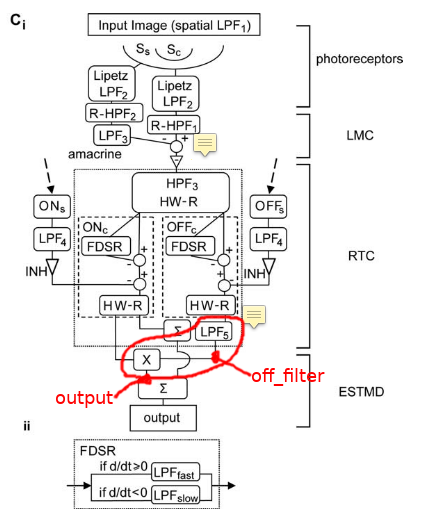

From Weiderman equation 4:

``Output = a.ON + b.D[OFF] + c.ON.D[OFF]``

and they say "In our simulations, we consider primarily the purely linear case (c=0), which we refer to as 'RTC', and the second-order case (a=b=0), refered to as 'ESTMD'"

Here, ``a_on`` is ``ON`` and ``off_filter`` is ``D[OFF]``

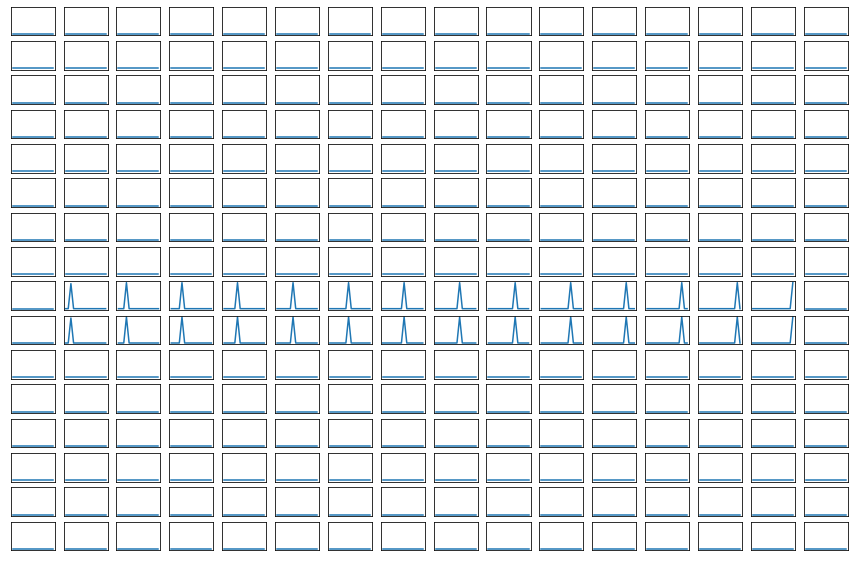

In [29]:
OFF_TAU = 25
OFF_K = np.exp(-1 / OFF_TAU)

off_filter = np.zeros((TIMESTEPS, HEIGHT, WIDTH))
output = np.zeros((TIMESTEPS, HEIGHT, WIDTH))

# Correlate (multiply) low-pass filtered off channel with on channel
for t in range(1, TIMESTEPS):
    off_filter[t] = ((1.0 - OFF_K) * a_off[t]) + (OFF_K * off_filter[t - 1]) 
    output[t] = off_filter[t] * a_on[t]

visualise([output])

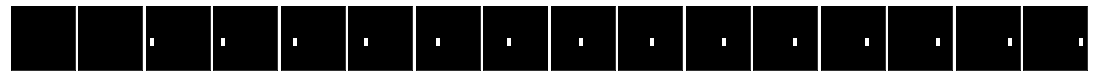

In [31]:
fig, axes = plt.subplots(1,TIMESTEPS, sharey=True, figsize=(15, 5))
for t, a in enumerate(axes):
    a.imshow(output[t,:,:], cmap="gray")
    hide_axes(a)
fig.tight_layout(pad=0)
